# U-Net: Training Image Segmentation Models in PyTorch

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of training U-Net, an image segmentation model in PyTorch on Orca Estimtor and SparkXShard of images. 

It is adapted from [U-Net: Training Image Segmentation Models in PyTorch](https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/) on [TGS Salt Segmentation Dataset](https://www.kaggle.com/c/tgs-salt-identification-challenge). 

In [ ]:
# Use seaborn for some plots
!pip install torch torchvision

In [ ]:
# import necessary libraries
from bigdl.orca.data.shard import SparkXShards

import bigdl.orca.data
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.learn.pytorch import Estimator
import numpy as np
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch.nn
import torch.optim as optim
from torchvision import transforms
from IPython.display import display

Start an OrcaContext and give a bit more memory.

In [ ]:
sc = init_orca_context(cluster_mode="local", cores=4, memory="8g")

##  Load images into SparkXShards in parallel

Load data into data_shards, it is a SparkXshards that can be operated on in parallel. Here each record is a tuple of (image: PIL.Image.Image and mask: PIL.Image.Image), and could be operated as 

In [4]:
input_dir = "../tsg_salt/images/"
target_dir = "../tsg_salt/masks/"
data_shards = bigdl.orca.data.read_images(input_dir, 
                                          target_path=target_dir, 
                                          image_type=".png", 
                                          target_type=".png")

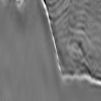

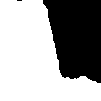

In [5]:
# take a look at the data
from PIL import ImageOps
image, mask = data_shards.first()
display(image)
mask = ImageOps.autocontrast(mask)
display(mask)

In [6]:
# see the num of partitions of data_shards
data_shards.num_partitions()


4

## Transformation of the images

Define a train_transform function directly using methods of torchvision transforms 

In [7]:
def train_transform(im):
    features = im[0]
    features = transforms.Resize((80, 80))(features)
    features = transforms.ToTensor()(features)
    features = features.numpy()

    targets = im[1]
    targets = transforms.Resize((80, 80))(targets)
    targets = transforms.ToTensor()(targets)
    targets = targets.numpy()
    return features, targets

In [8]:
data_shards = data_shards.transform_shard(train_transform)

Stack elements of each partition into an ndarray of features and labels for efficient training

In [9]:
data_shards = data_shards.stack_feature_labels()

## The model

Build the U-Net model model as usual. Here, model is adapted from https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/.

In [10]:
img_size = (80, 80)

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1])
                                     for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs


class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and decoder blocks
        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                      for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True,
                 outSize = (img_size[0], img_size[1])):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

define a model_creator for Orca Estimator and show the summary of model structure

In [11]:
def model_creator(config):
    model = UNet()
    model.train()
    print(model)
    return model

define the loss function, optimizer

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()

def optimizer_creator(model, config):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return optimizer

define an Orca Estimator and train the model

In [13]:
orca_estimator = Estimator.from_torch(model=model_creator,
                                      optimizer=optimizer_creator,
                                      loss=criterion,
                                      metrics=[criterion],
                                      backend="spark")

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), str

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
orca_estimator.fit(data=data_shards, epochs=EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
stop_orca_context()